In [1]:
# import the necessary packages
import os

from scipy.fft import fft2

import numpy as np
from PIL import Image
import cv2

import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

import stitching as st

from IPython.display import clear_output

In [2]:
imagePath = '/home/jack/Videos/map_2_images/'
imageExtension = 'png'
fileTemplateName = 'image'

detectoryType = 'akaze'

images = [imagePath + i for i in os.listdir(imagePath) if imageExtension in i]
imageIndexing = [int(img.split(fileTemplateName)[-1].split('.')[0]) for img in images]

images = np.array(images)[np.argsort(imageIndexing)]

100%|█████████████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.83it/s]


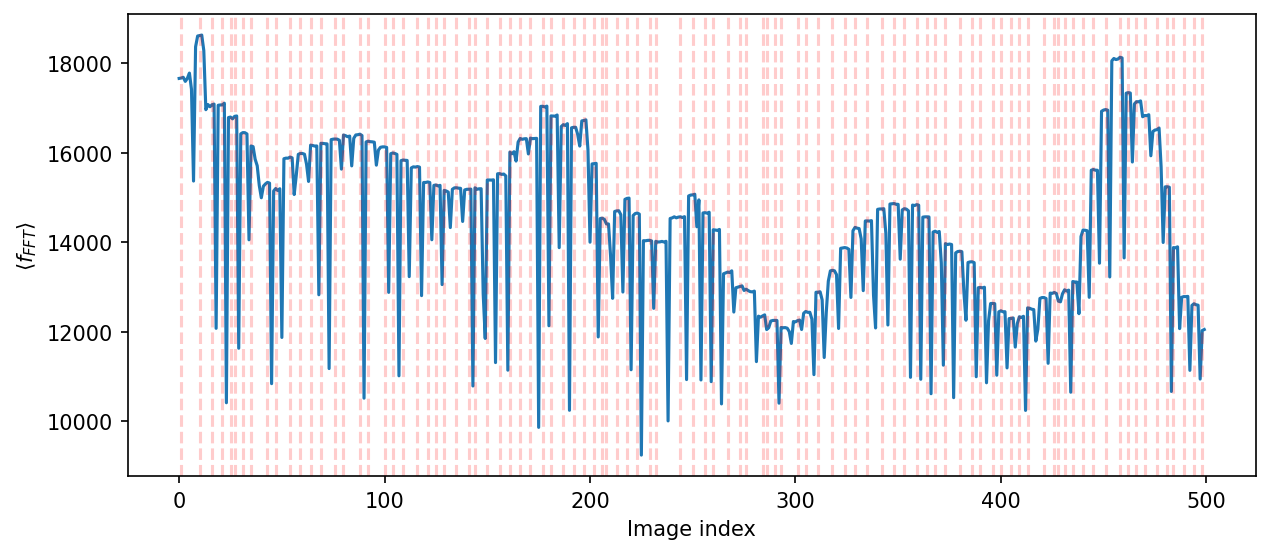

Found 97 stable images


In [48]:
stableImageIndices = st.identifyStableImages(images[:500], derThreshold=.05, debug=True)
print(f'Found {len(stableImageIndices)} stable images')

In [49]:
stitchedOffsets = [[0,0]]
stitchedRotations = [0]

imgArr = [cv2.imread(images[i]) for i in stableImageIndices]

fd = st.FeatureDetector('akaze')
features = [fd.detect_features(np.mean(imgArr[i], axis=-1)) for i in range(len(imgArr))]

for i in tqdm.tqdm(range(len(imgArr)-1)):

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(features[i]["descriptors"], features[i+1]["descriptors"], k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    da = []
    dr = []

    for match in good:
        keypoint1 = features[i]["keypoints"][match.queryIdx]
        keypoint2 = features[i+1]["keypoints"][match.trainIdx]

        dr.append(np.array(keypoint1.pt) - np.array(keypoint2.pt))
        da.append(keypoint1.angle - keypoint2.angle)

    # Fix periodicity
    da = np.where(np.array(da) > 180, np.array(da) - 360, da)
    da = np.where(np.array(da) < -180, np.array(da) + 360, da)

    dr = np.array(dr)
    
    stitchedOffsets.append(np.median(dr, axis=0))
    stitchedRotations.append(np.median(da))
    
stitchedOffsets = np.array(stitchedOffsets)
stitchedRotations = np.array(stitchedRotations)

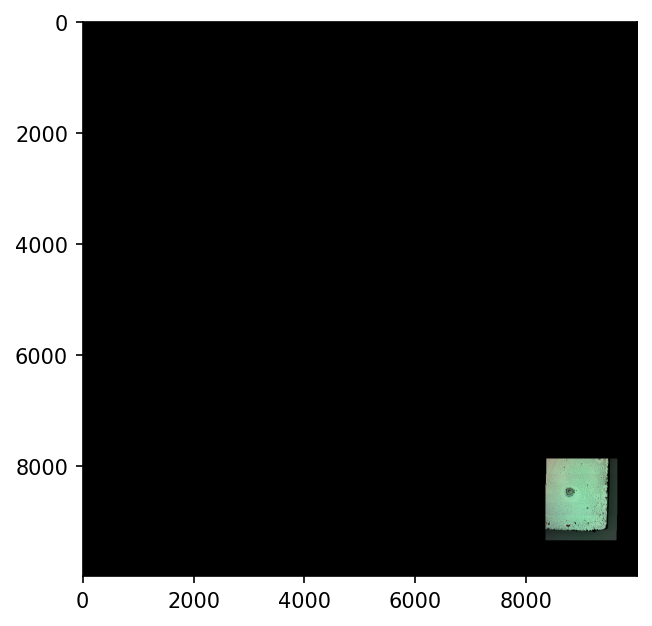

In [74]:
# concat images
approxStitchSize = (5*int(np.abs(np.sum(stitchedOffsets[:,0]))),
                    5*int(np.abs(np.sum(stitchedOffsets[:,0]))))

approxStitchSize = (12000, 12000)

stitchedImage = Image.new('RGB', approxStitchSize)
currOffset = np.array([5*approxStitchSize[0]/6, 5*approxStitchSize[1]/6])
currRotation = 0

for i in range(len(imgArr[:3])):
    currOffset = currOffset + stitchedOffsets[i]
    
    # Grab what the region that is about to be pasted over looks like
    currRegionImg = np.array(stitchedImage.rotate(-currRotation, center=(currOffset[1]+imgArr[i].shape[0]/2, currOffset[0]+imgArr[i].shape[1]/2)), dtype=np.float64)[int(currOffset[1]):int(currOffset[1])+imgArr[i].shape[0],int(currOffset[0]):int(currOffset[0])+imgArr[i].shape[1]]
    currRegionImg[currRegionImg == 0] = np.nan
    
    oldHorizontalGrad = np.array([np.nanmedian(currRegionImg[:,j,:], axis=0) for j in range(currRegionImg.shape[1])])
    oldVerticalGrad = np.array([np.nanmedian(currRegionImg[j,:,:], axis=0) for j in range(currRegionImg.shape[0])])
    
    newHorizontalGrad = np.array([np.median(imgArr[i][:,j,:], axis=0) for j in range(imgArr[i].shape[1])])
    newVerticalGrad = np.array([np.median(imgArr[i][j,:,:], axis=0) for j in range(imgArr[i].shape[0])])

#     plt.plot(oldHorizontalGrad, label='old')
#     plt.plot(newHorizontalGrad, label='new')
#     plt.legend()
#     plt.show()
    
#     plt.plot(oldVerticalGrad, label='old')
#     plt.plot(newVerticalGrad, label='new')
#     plt.legend()
#     plt.show()
    
    img = np.where(1 - np.isnan(currRegionImg), imgArr[i]*.5 + currRegionImg*.5, imgArr[i])
    
    img = Image.fromarray(img.astype(np.uint8))
    img.rotate(currRotation + stitchedRotations[i])

    # plt.imshow(currRegionImg.astype(np.uint8))
    # plt.show()
    
    stitchedImage.paste(img, (int(currOffset[0]), int(currOffset[1])))
    currRotation += stitchedRotations[i]

plt.imshow(stitchedImage)
plt.show()

In [73]:
stitchedImage.save('test_stitch.png')